In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from matplotlib.patches import Ellipse

def plot_biplot(data, feature_names):
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[feature_names])

    # Apply LDA
    lda = LDA(n_components=2)  # Limit to 2 components for visualization
    X_lda = lda.fit_transform(X_scaled, data['NeuronType'])

    # Create a DataFrame for the transformed data
    lda_df = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
    lda_df['NeuronType'] = data['NeuronType']

    # Calculate scaling factor for 95% confidence ellipse (Chi-square value)
    scaling_factor = np.sqrt(5.991)

    # Retrieve the explained variance ratio from the LDA model
    explained_variance_ratio = lda.explained_variance_ratio_ * 100  # Convert to percentage

    # Plotting
    plt.figure(figsize=(10, 7))

    # Define a specific color palette from seaborn for clarity
    palette = sns.color_palette("Set1", n_colors=len(lda_df['NeuronType'].unique()))

    # Map NeuronType to the palette
    color_map = dict(zip(lda_df['NeuronType'].unique(), palette))

    # Plot the LDA data with corrected NeuronType colors
    sns.scatterplot(x='LD1', y='LD2', hue='NeuronType', data=lda_df, palette=color_map, s=100, alpha=0.7)

    # Add ellipses with corrected colors
    for neuron_type in lda_df['NeuronType'].unique():
        sub_data = lda_df[lda_df['NeuronType'] == neuron_type]
        covariance = np.cov(sub_data[['LD1', 'LD2']].T)
        lambda_, v = np.linalg.eig(covariance)
        lambda_ = np.sqrt(lambda_) * scaling_factor  # Adjust the eigenvalues
        ell = Ellipse(xy=(np.mean(sub_data['LD1']), np.mean(sub_data['LD2'])),
                      width=lambda_[0]*2, height=lambda_[1]*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor=color_map[neuron_type], fc='None', lw=2, linestyle='--')
        plt.gca().add_patch(ell)

    # Adjusting vector scaling for better fit
    scale_factor = 2  # Same scale factor for consistency
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, lda.scalings_[i, 0]*scale_factor, lda.scalings_[i, 1]*scale_factor, color='black', head_width=0.05, head_length=0.1)
        plt.text(lda.scalings_[i, 0]*scale_factor*1.2, lda.scalings_[i, 1]*scale_factor*1.2, feature, color='black')

    plt.xlabel(f'LD1 ({explained_variance_ratio[0]:.2f}%)')
    plt.ylabel(f'LD2 ({explained_variance_ratio[1]:.2f}%)')
    plt.title('LDA Analysis of Neuron Types')
    plt.legend(title='Neuron Type')
    plt.grid(True)
    plt.show()

def plot_density(data, feature_names):
    X = data[feature_names]

    # Encode the target variable
    le = LabelEncoder()
    y = le.fit_transform(data['NeuronType'])
    y_labels = le.inverse_transform(y)

    # Apply LDA
    lda = LDA()
    X_lda = lda.fit_transform(X, y)

    # Create a DataFrame for LDA results
    lda_df = pd.DataFrame(X_lda, columns=['LD1'])
    lda_df['NeuronType'] = y_labels

    # Plot the LDA results
    fig, ax = plt.subplots(figsize=(10, 6))
    palette = sns.color_palette("Set1", len(np.unique(y_labels)))
    sns.scatterplot(x='LD1', y=np.zeros(len(lda_df)), hue='NeuronType', data=lda_df, palette=palette, s=50, edgecolor='k')

    # Kernel density estimate and plot
    medians = {}
    for label, color in zip(np.unique(y_labels), palette):
        class_data = lda_df[lda_df['NeuronType'] == label]['LD1']
        kde = stats.gaussian_kde(class_data)
        x_range = np.linspace(lda_df['LD1'].min(), lda_df['LD1'].max(), 100)
        y_values = kde(x_range)
        y_normalized = y_values / y_values.max() * 0.4  # Normalize the peak for visualization
        ax.fill_between(x_range, y_normalized, alpha=0.3, color=color, label=f'{label} Density')
        # Calculate and store medians
        medians[label] = np.median(class_data)

    # Plot vertical lines for medians and add text annotations
    for label, color in zip(np.unique(y_labels), palette):
        median = medians[label]
        ax.axvline(median, color=color, linestyle='--', linewidth=1)
        ax.text(median, 0.45, f'{label}\nMedian: {median:.2f}', color=color, ha='center', va='top', fontsize=8, rotation=90)

    # Calculate distances between medians and plot these
    sorted_medians = sorted(medians.items(), key=lambda x: x[1])
    for i in range(len(sorted_medians) - 1):
        label1, median1 = sorted_medians[i]
        label2, median2 = sorted_medians[i + 1]
        distance = median2 - median1
        ax.text((median1 + median2) / 2, 0.1, f'Dist: {distance:.2f}', ha='center', va='bottom', fontsize=8, color='black')
        ax.hlines(0.1, median1, median2, colors='gray', linestyles='--', linewidth=1)

    # Custom legend creation
    handles, labels = ax.get_legend_handles_labels()
    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color, linestyle='None') for label, color in zip(np.unique(y_labels), palette)]
    density_legend = [plt.Line2D([0], [0], color=color, label=f'{label} Density', linewidth=10, alpha=0.3) for label, color in zip(np.unique(y_labels), palette)]
    plt.legend(handles=custom_legend, loc='upper right', title='Groups')

    ax.set_title('LDA Analysis of Neuron Types')
    ax.set_xlabel('Linear Discriminant 1')
    ax.set_ylabel('Density')
    ax.set_ylim([-0.05, 0.5])
    plt.show()


def lda_plot(file_path):
    """
    This function performs Linear Discriminant Analysis (LDA) on the given dataset and plots the density of the first
    linear discriminant for different neuron types.

    Parameters:
    file_path (str): Path to the CSV file containing the dataset.
    """
    data = pd.read_csv(file_path)
    data = data.replace(np.nan, 0.0)
    feature_names = ['mean_IBI', 'mean_Burst_Peak', 
            'mean_Burst_Peak_Abs',  'Number_Bursts',
            'mean_Spike_per_Burst', 'mean_BurstDuration',
            'MeanNetworkISI', 'MeanWithinBurstISI', 
            'MeanOutsideBurstISI','Fanofactor']
    unique_classes = data['NeuronType'].unique()
    if len(unique_classes) == 2:
        plot_density(data, feature_names)
    elif len(unique_classes) > 2:
        plot_biplot(data, feature_names)

In [11]:
two_class_file_csv = '/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/2024 Summer/CSRA/Outputs/SYNGAP_ALL/Network/Compiled_Networks.csv'

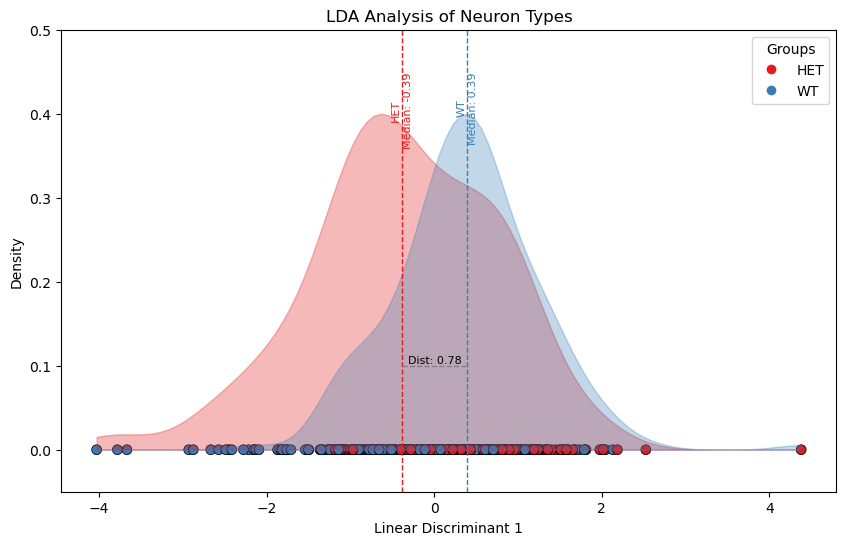

In [12]:
lda_plot(two_class_file_csv)

In [13]:
from sklearn.datasets import make_classification
import numpy as np

# Feature names for the synthetic dataset
feature_names = [
    'mean_IBI', 'mean_Burst_Peak', 'mean_Burst_Peak_Abs', 'Number_Bursts',
    'mean_Spike_per_Burst', 'mean_BurstDuration', 'MeanNetworkISI',
    'MeanWithinBurstISI', 'MeanOutsideBurstISI', 'Fanofactor'
]

# Generate synthetic data with 3 classes and 10 features
X, y = make_classification(n_samples=300, n_features=len(feature_names), n_informative=8, n_redundant=2, n_classes=3, random_state=42)

# Create a DataFrame to mimic the original dataset structure
synthetic_data = pd.DataFrame(X, columns=feature_names)

# Map the integer classes to string labels similar to original NeuronType ('Class1', 'Class2', 'Class3')
neuron_type_map = {0: 'Class1', 1: 'Class2', 2: 'Class3'}
synthetic_data['NeuronType'] = [neuron_type_map[label] for label in y]

# Display the first few rows of the generated synthetic dataset
synthetic_data.head()

# generate csv
synthetic_data.to_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/2024 Summer/CSRA/Outputs/SYNGAP_ALL/Network/Synthetic_Compiled_Networks.csv', index=False)

In [14]:
three_class_file_csv = '/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/2024 Summer/CSRA/Outputs/SYNGAP_ALL/Network/Synthetic_Compiled_Networks.csv'

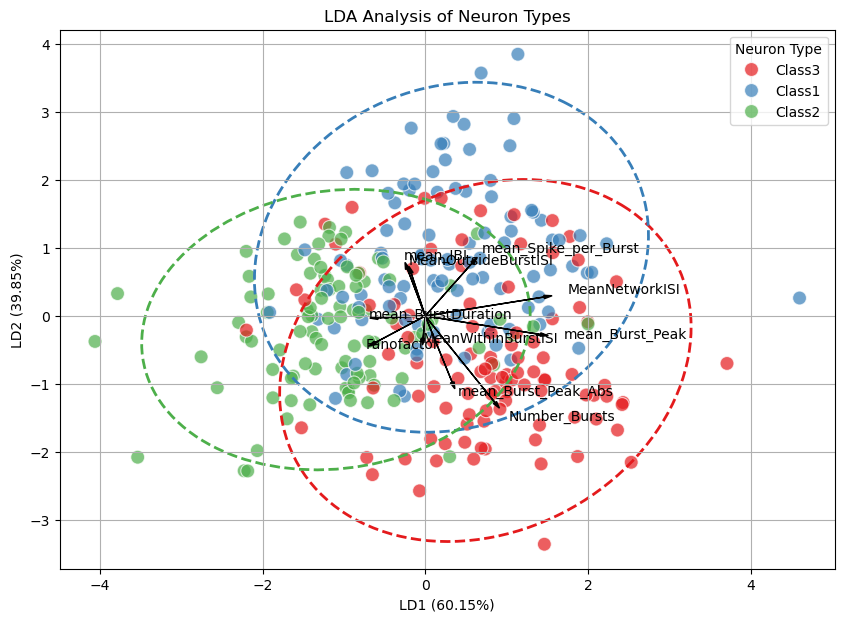

In [15]:
lda_plot(three_class_file_csv)